In [445]:
import imp
from utils import *
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [446]:
class OLS(object):
    def __init__(self, beta_true = None):
        self.model = LinearRegression()

    def fit(self, x, y, **options):
        n, p = x.shape
        # Set the sample weights
        if 'weights' in options:
            self.weights = np.reshape(options['weights'], [n,])
        else:
            self.weights = np.ones([n,])

        # Fit the model and get the parameter
        self.model.fit(x, y, sample_weight = self.weights)
        self.beta = np.reshape(self.model.coef_, [p, 1]) # 斜率
        self.intercept = np.reshape(self.model.intercept_, [1, 1]) # 截距 
        self.coef = np.concatenate((self.intercept, self.beta), axis = 0)

    def predict(self, x_test):
        return np.matmul(x_test, self.beta) + self.intercept

In [447]:
class LASSO(object):
    def __init__(self, alpha = 1):
        self.model = Lasso(alpha)
        
    def fit(self, x, y, weights = None):
        n, p = x.shape
        if weights != None:
            self.weights = np.reshape(weights, (n, ))
        else:
            self.weights = np.ones((n, ))

        self.model.fit(x, y, sample_weight=self.weights)
        self.beta = np.reshape(self.model.coef_, [p, 1])
        self.intercept = np.reshape(self.model.intercept_, [1, 1])
        self.coef = np.concatenate((self.intercept, self.beta), axis = 0)
        
    def predict(self, x_test):
        return np.matmul(x_test, self.beta) + self.intercept

In [448]:
class EL_NET(object):
    def __init__(self):
        self.model = ElasticNet()
        
    def fit(self, x, y, weights = None):
        n, p = x.shape
        if weights != None:
            self.weights = np.reshape(weights, (n, ))
        else:
            self.weights = np.ones((n, ))
            
        self.model.fit(x, y, sample_weight=self.weights)
        self.beta = np.reshape(self.model.coef_, [p, 1])
        self.intercept = np.reshape(self.model.intercept_, [1, 1])
        self.coef = np.concatenate((self.intercept, self.beta), axis=0)
        
    def predict(self, x_test):
        return self.model.predict(x_test)

# ULasso
$$
\text{min}\ \parallel Y-\pmb{X}\beta \parallel ^2_2 + \lambda_1 \parallel \beta \parallel_1 + \lambda_2 \beta^T \pmb{C} \beta
$$

$$
C_{jk}=r_{jk}^2,\quad r_{jk}=\frac{1}{n}|\pmb{X}_{,j}^T\pmb{X}_{,k}|
$$

In [449]:
class ULasso(object):
    def __init__(self, data_x, data_y, alpha = 1.0, regu1=0.35, regu2=1, maxiter = 1000):
         self.X = np.concatenate((np.ones((data_x.shape[0],1)), data_x), axis=1)
         self.Y = data_y
         self.regu1 = regu1
         self.regu2 = regu2
         self.coef = np.ones((self.X.shape[1], 1)) # initialization coef
         self.sample_weights = np.ones(data_x.shape[0], )
         self.C = np.ones((self.X.shape[1], self.X.shape[1]))
         self.maxiter = maxiter
         self.alpha = alpha
         
    def predict(self, X):
        X = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
        y_pred = np.matmul(X, self.coef)
        return y_pred
    
    def get_C(self, X):
        n, p = X.shape
        for i in range(p):
            for j in range(p):
                col1 = X[:, i].squeeze()
                col2 = X[:, j].squeeze()
                r = np.abs(np.dot(col1, col2)) / n
                self.C[i][j] = r ** 2
        
        
    def loss_function(self, coef):
        n, p = self.X.shape
        self.get_C(self.X)
        self.coef = coef
        y_true = self.Y.squeeze()
        y_pred = np.matmul(self.X, self.coef).squeeze()
        model_error = np.sum(self.sample_weights * np.square(y_true - y_pred))
        coef_r = coef.squeeze()
        func_error = model_error + self.alpha * self.regu1 * np.sum(coef) + self.alpha * self.regu2 * np.dot(np.dot(coef_r, self.C), coef_r)
        return func_error
        
    def fit(self):
        res = minimize(self.loss_function, self.coef, method='BFGS', options={'maxiter': self.maxiter})
        self.coef = res.x
         

# IILasso
$$
\text{min}\ \parallel Y-\pmb{X}\beta \parallel_2^2 + \lambda_1 \parallel \beta \parallel_1 + \lambda_2 |\beta^T| \pmb{R} |\beta|
$$

$$
R_{jk}=|r_{jk}| / (1-|r_{jk}|),\quad r_{jk}=\frac{1}{n} |\pmb{X}^T_{,j}\pmb{X}_{,k}|
$$

In [450]:
class IILasso(object):
    def __init__(self, data_x, data_y, alpha = 1, regu1 = 0.5, regu2 = 0.5, maxiter = 1000):
        self.X = np.concatenate((np.ones((data_x.shape[0], 1)), data_x), axis=1)
        self.Y = data_y
        self.alpha = alpha
        self.regu1 = regu1
        self.regu2 = regu2
        self.maxiter = maxiter
        self.coef = np.ones((self.X.shape[1], 1))
        self.sample_weights = np.ones((self.X.shape[0],))
        self.R = np.ones((self.X.shape[1], self.X.shape[1]))
        
    def predict(self, X):
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        y_pred = np.matmul(X, self.coef)
        return y_pred
    
    def get_R(self, X):
        n, p = X.shape
        for i in range(p):
            for j in range(p):
                if i == j:
                    self.R[i][j] = 0
                else:
                    col1 = X[:, i].squeeze()
                    col2 = X[:, j].squeeze()
                    r = np.abs(np.dot(col1, col2)) / n
                    self.R[i][j] = r / (1 - r)
                
    def loss_function(self, coef):
        n, p = self.X.shape
        self.get_R(self.X)
        self.coef = coef
        y_true = self.Y.squeeze()
        y_pred = np.matmul(self.X, coef).squeeze()
        model_error = np.sum(self.sample_weights * np.square(y_true - y_pred))
        coef_r = coef.squeeze()
        func_error = model_error + self.regu1 * np.sum(coef_r) + self.regu2 * np.dot(np.dot(np.abs(coef_r), self.R), np.abs(coef_r))
        return func_error
    
    def fit(self):
        res = minimize(self.loss_function, self.coef, method='BFGS', options={'maxiter': self.maxiter})
        self.coef = res.x

In [451]:
X_list, Y_list = [], []
for i in range(6):
    x = np.load('House_Data/X'+str(i)+'.npy')
    y = np.load('House_Data/Y'+str(i)+'.npy')
    X_list.append(x)
    Y_list.append(y)

In [452]:
for i in range(6):
    x, y = X_list[i], Y_list[i]
    w_stat = weighted_stat(x, np.ones(y.shape))
    # default by indentity.
    print('======Envrionment %4d============' % (i))
    print('Original Correlation: ', w_stat['mean_corr'])
    print('Original Collinearity: ', w_stat['CN'])

======Envrionment    0============
Original Correlation:  0.19463977288355847
Original Collinearity:  41.28751156758869
======Envrionment    1============
Original Correlation:  0.20517168815940565
Original Collinearity:  42.333709959295646
======Envrionment    2============
Original Correlation:  0.19539134384534926
Original Collinearity:  34.80208300624458
======Envrionment    3============
Original Correlation:  0.1844833299748109
Original Collinearity:  33.44420625408224
======Envrionment    4============
Original Correlation:  0.1786383434270527
Original Collinearity:  31.203442363271016
======Envrionment    5============
Original Correlation:  0.16375951007089282
Original Collinearity:  31.941753947565097


In [453]:
np.random.seed(0)
train_ind = 0
x_train_whole, y_train_whole = X_list[train_ind], Y_list[train_ind]
sample_index = np.random.choice(x_train_whole.shape[0], 500, replace=False)
unsample_index = [x for x in range(len(x_train_whole)) if not (x in sample_index)]

x_train, y_train = x_train_whole[sample_index], y_train_whole[sample_index]
scaler = preprocessing.StandardScaler().fit(x_train) # 标准化
x_train_scaled = scaler.transform(x_train)
x_iid_test, y_iid_test = scaler.transform(x_train_whole[unsample_index]), y_train_whole[unsample_index] # 利用训练集中的统计指标标准化

In [454]:
w_stat = weighted_stat(x_train_scaled, np.ones(y_train.shape))
print('Original Correlation: ', w_stat['mean_corr'])
print('Original Collinearity: ', w_stat['CN'])

Original Correlation:  0.2170941630425216
Original Collinearity:  51.51486885287824


In [455]:
ols = OLS()
ols.fit(x_train_scaled, y_train)

lasso = LASSO()
lasso.fit(x_train_scaled, y_train)

ELNET = EL_NET()
ELNET.fit(x_train_scaled, y_train)

ulasso = ULasso(x_train_scaled, y_train)
ulasso.fit()

iilasso = IILasso(x_train_scaled, y_train)
iilasso.fit()

In [456]:
rmse_ols = []
rmse_lasso = []
rmse_ELNET = []
rmse_ulasso = []
rmse_iilasso = []
for i in range(6):
    if i == train_ind:
        x_test, y_test = x_iid_test, y_iid_test
    else:
        x_test, y_test = scaler.transform(X_list[i]), Y_list[i]
    rmse_ols.append(cal_prediction_error(y_test, ols.predict(x_test), 'rmse'))
    rmse_lasso.append(cal_prediction_error(y_test, lasso.predict(x_test), 'rmse'))
    rmse_ELNET.append(cal_prediction_error(y_test, ELNET.predict(x_test), 'rmse'))
    rmse_ulasso.append(cal_prediction_error(y_test, ulasso.predict(x_test), 'rmse'))
    rmse_iilasso.append(cal_prediction_error(y_test, iilasso.predict(x_test), 'rmse'))

In [457]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

def column_wise_resampling(x, replacement = False, random_state = 0, **options):
    """
    Perform column-wise random resampling to break the joint distribution of p(x).
    In practice, we can perform resampling without replacement (a.k.a. permutation) to retain all the data points of feature x_j. 
    Moreover, if the practitioner has some priors on which features should be permuted,
    it can be passed through options by specifying 'sensitive_variables', by default it contains all the features
    """
    rng = np.random.RandomState(random_state)
    n, p = x.shape
    if 'sensitive_variables' in options:
        sensitive_variables = options['sensitive_variables']
    else:
        sensitive_variables = [i for i in range(p)] 
    x_decorrelation = np.zeros([n, p])
    for i in sensitive_variables:
        var = x[:, i]
        if replacement: # sampling with replacement
            x_decorrelation[:, i] = np.array([var[rng.randint(0, n)] for j in range(n)])
        else: # permutation     
            x_decorrelation[:, i] = var[rng.permutation(n)]
    return x_decorrelation

def decorrelation(x, solver = 'adam', hidden_layer_sizes = (2,), max_iter = 500, random_state = 0, clip_range = 0.9):
    """
    Calcualte new sample weights by density ratio estimation
           q(x)   P(x belongs to q(x) | x) 
    w(x) = ---- = ------------------------ 
           p(x)   P(x belongs to p(x) | x)

    If default == True, then a single hidden layer perceptron will be used as binary classifier, 
    otherwise you can specify it by 'classifier', it must have 'fit' and 'predict_proba' api according to sklearn API standard.
    """
    n, p = x.shape
    x_decorrelation = column_wise_resampling(x, random_state = random_state)
    P = pd.DataFrame(x)
    Q = pd.DataFrame(x_decorrelation)
    P['src'] = 1 # 1 means source distribution
    Q['src'] = 0 # 0 means target distribution
    Z = pd.concat([P, Q], ignore_index=True, axis=0)
    labels = Z['src'].values
    Z = Z.drop('src', axis=1).values
    P, Q = P.values, Q.values

    # Train a binary classifier to classify the source and target distribution
    clf = MLPClassifier(solver=solver, hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=random_state)
    clf.fit(Z, labels)
    proba = np.clip(clf.predict_proba(Z)[:len(P), 1], 1-clip_range, clip_range)
    weights = (1./proba) - 1. # calculate sample weights by density ratio
    weights /= np.mean(weights) # normalize the weights to get average 1
    weights = np.reshape(weights, [n,])
    return weights

In [458]:
ols_our = OLS()
w = decorrelation(x_train_scaled, max_iter=1000, hidden_layer_sizes=(3,))
w_stat = weighted_stat(x_train_scaled, w)
print('Decorrelated Correlation: ', w_stat['mean_corr'])
print('Decorrelated Collinearity: ', w_stat['CN'])
print('Start fitting')

ols_our.fit(x_train_scaled, y_train, weights=w)
rmse_ols_our = []
for i in range(6):
    if i == train_ind:
        x_test, y_test = x_iid_test, y_iid_test
    else:
        x_test, y_test = scaler.transform(X_list[i]), Y_list[i]
    rmse_ols_our.append(cal_prediction_error(y_test, ols_our.predict(x_test)))
print('ave_RMSE(std) of OLS: %.4f(%.4f)'%(np.mean(rmse_ols), np.std(rmse_ols)))
print('ave_RMSE(std) of LASSO: %.4f(%.4f)'%(np.mean(rmse_lasso), np.std(rmse_lasso)))
print('ave_RMSE(std) of Elastic Net: %.4f(%.4f)'%(np.mean(rmse_ELNET), np.std(rmse_ELNET)))
print('ave_RMSE(std) of ULASSO: %.4f(%.4f)'%(np.mean(rmse_ulasso), np.std(rmse_ulasso)))
print('ave_RMSE(std) of IILASSO: %.4f(%.4f)'%(np.mean(rmse_iilasso), np.std(rmse_iilasso)))
print('ave_RMSE(std) of OLS+Our: %.4f(%.4f)'%(np.mean(rmse_ols_our), np.std(rmse_ols_our)))

Decorrelated Correlation:  0.15337498374949854
Decorrelated Collinearity:  17.197719725581518
Start fitting
ave_RMSE(std) of OLS: 365078.1571(137313.6264)
ave_RMSE(std) of LASSO: 365078.9347(137316.2037)
ave_RMSE(std) of Elastic Net: 283197.7813(80734.1383)
ave_RMSE(std) of ULASSO: 362656.6926(135968.5022)
ave_RMSE(std) of IILASSO: 358570.9001(133504.4891)
ave_RMSE(std) of OLS+Our: 249206.1521(47224.5792)


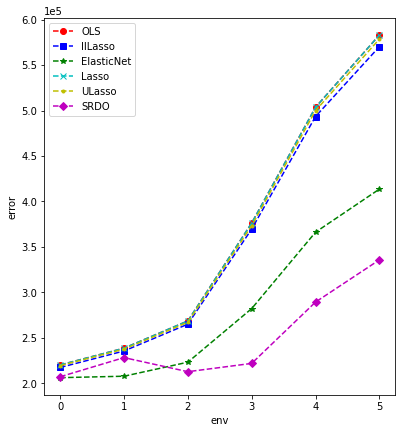

In [459]:
fig = plt.figure(figsize=(6,6))

plt.plot(np.arange(6), rmse_ols, 'r--', marker='o', label='OLS')
plt.plot(np.arange(6), rmse_iilasso, 'b--', marker='s', label='IILasso')
plt.plot(np.arange(6), rmse_ELNET, 'g--', marker='*', label='ElasticNet')
plt.plot(np.arange(6), rmse_lasso, 'c--', marker='x', label='Lasso')
plt.plot(np.arange(6), rmse_ulasso, 'y--', marker='.', label='ULasso')
plt.plot(np.arange(6), rmse_ols_our, 'm--', marker='D', label='SRDO')

plt.xlabel('env')
plt.ylabel('error')

fig.tight_layout()
plt.ticklabel_format(style = 'sci', scilimits = (-1, 2), axis = 'y')
plt.legend()
plt.show()